In [142]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import cvxpy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt


In [143]:
np.random.seed(42)

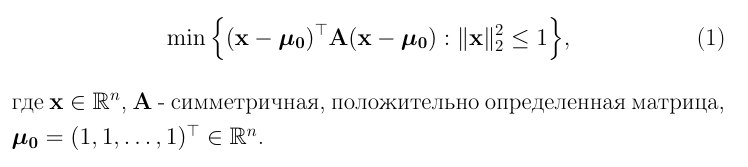

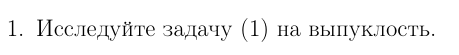

Функция $f(x)$ является квадратичной формой относительно $x$. 
Гессиан (вторая производная) этой функции $H(x) = 2A$. По условию матрица $A$ положительно определена, а значит и матрица $2A$ тоже положительно определена. Из этого следует, что функция $f(x)$ является выпуклой.

Ограничение можно записать как $g(x) = x^Tx \le 1$. Первая производная равна $2x$, а гессиан равен $2I$, где $I$ - единичная матрица. $2I$ положительно определена, а значит $g(x)$ - выпуклая функция. Из этого следует, что и ограничение $g(x) \le 1$ - выпуклое множество. Также можно сказать, что это это множество соответствует единичному шару в $\mathbb{R}^n$.

Таким образом, поскольку и функция цели, и множество ограничений выпуклы, оптимизационная задача является выпуклой.

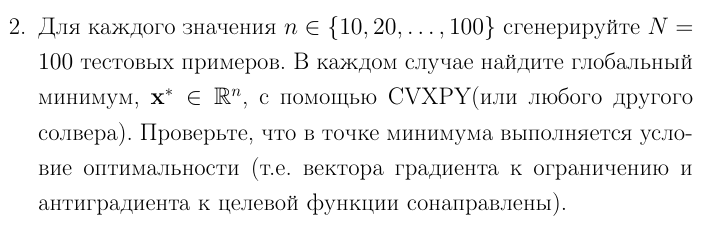

In [144]:
def solve_elipsoid(A, mu):

    x = cp.Variable(A.shape[0])

    objective = cp.Minimize(cp.quad_form(x - mu, A))

    constraints = [cp.norm2(x) <= 1]

    prob = cp.Problem(objective, constraints)

    result = prob.solve()

    return [x.value, result]

In [145]:
def solve_rand_elipsoids(
    n_dim: int = 2, n_samples: int = 100, random_states: list = None
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]

    cases = []

    for A in affine_ops:

        cases.append([A] + list(solve_elipsoid(A, mu)))

    return cases

In [146]:
def quadform_grad(A, x, mu):
    return (A + A.T) @ x - (A + A.T) @ mu

In [147]:
def constraint_grad(x):
    return 2 * x

In [148]:
def is_kkt_optimal(grad_obj, grad_constraint, eps=0.01):

    dot = np.dot(-grad_obj, grad_constraint)
    norm_f = np.linalg.norm(grad_obj)
    norm_g = np.linalg.norm(grad_constraint)
    if norm_f < eps or norm_g < eps:
        return True
    cos_angle = dot / (norm_f * norm_g)
    
    return bool((cos_angle - 1 < eps).all())

In [149]:
ndims = range(10, 110, 10)

In [150]:
print("+---------------------------------------+")
for dim in ndims:
    mu = np.ones(dim)
    time_start = time.time()
    all_optim_flag = np.all(
            np.asarray(
                [
                    is_kkt_optimal(
                        quadform_grad(case[0], case[1], mu), constraint_grad(case[1])
                    )
                    for case in solve_rand_elipsoids(dim)
                ]
            )
        )
    time_total = (time.time()-time_start)

    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    print(
        f"| dim={dim_str} | {all_optim_flag} | avg_time: {time_total/100:.4f} sec |",
    )
print("+---------------------------------------+")

print("^_^")

+---------------------------------------+
| dim=10  | True | avg_time: 0.0034 sec |
| dim=20  | True | avg_time: 0.0033 sec |
| dim=30  | True | avg_time: 0.0044 sec |
| dim=40  | True | avg_time: 0.0047 sec |
| dim=50  | True | avg_time: 0.0073 sec |
| dim=60  | True | avg_time: 0.0068 sec |
| dim=70  | True | avg_time: 0.0082 sec |
| dim=80  | True | avg_time: 0.0084 sec |
| dim=90  | True | avg_time: 0.0648 sec |
| dim=100 | True | avg_time: 0.0963 sec |
+---------------------------------------+
^_^


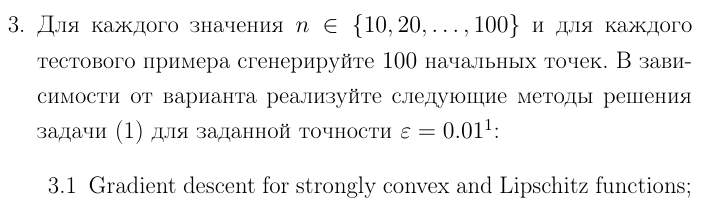

In [151]:
def project_to_constraint(x):
    x_norm = np.linalg.norm(x)
    return x if x_norm <= 1 else x / x_norm

def gradient_descent(A, mu, x_init, f_star, eps=0.01, max_iters=10000):
    L = 2 * np.linalg.norm(A, 2)
    alpha = 1.0 / L
    x = x_init.copy()
    iterations = 0


    while iterations < max_iters:
        grad = quadform_grad(A, x, mu)
        x_new = project_to_constraint(x - alpha * grad)
        f_val = (x_new - mu).T @ A @ (x_new - mu)

        x = x_new
        iterations += 1

        if f_val - f_star <= eps:
            break

    return x_new, iterations, f_val

In [152]:
def gd_rand_elipsoids_avg_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    iters_total = 0
    time_total = 0

    for A in affine_ops:

        solution = solve_elipsoid(A, mu)

        case_time_start = time.time()

        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            assert is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt))

            iters_total += iters
            
        time_total += time.time() - case_time_start

    return time_total/(n_samples*n_init_states) , iters_total/(n_samples*n_init_states)

In [153]:
print("+-----------------------------------------------------+")
for dim in ndims:
    
    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    stat = gd_rand_elipsoids_avg_stats(dim)

    print(
        f"| dim={dim_str} | avg_iters: {stat[1]:.4f} | avg_time: {stat[0]:.4f} sec |",
    )
print("+-----------------------------------------------------+")

print("^_^")

+-----------------------------------------------------+
| dim=10  | avg_iters: 14.8383 | avg_time: 0.0001 sec |
| dim=20  | avg_iters: 19.7400 | avg_time: 0.0002 sec |
| dim=30  | avg_iters: 23.6962 | avg_time: 0.0003 sec |
| dim=40  | avg_iters: 24.7885 | avg_time: 0.0003 sec |
| dim=50  | avg_iters: 26.8277 | avg_time: 0.0004 sec |
| dim=60  | avg_iters: 31.9977 | avg_time: 0.0006 sec |
| dim=70  | avg_iters: 32.8671 | avg_time: 0.0007 sec |
| dim=80  | avg_iters: 37.5406 | avg_time: 0.0009 sec |
| dim=90  | avg_iters: 35.7857 | avg_time: 0.0011 sec |
| dim=100 | avg_iters: 44.4046 | avg_time: 0.0031 sec |
+-----------------------------------------------------+
^_^


#5

In [154]:
def gd_rand_elipsoids_sol_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    cases = []

    for i, A in enumerate(affine_ops):

        solution = solve_elipsoid(A, mu)

        eig_vigals = np.sort(np.abs(np.linalg.eigvals(A)))
        ev_ratio = eig_vigals[-1] /  eig_vigals[0]


        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            assert is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt))

            cases.append({
                "example_id" : i,
                "ev_ratio": ev_ratio,
                "solution_delta": np.abs(solution[-1] - f_val),
                "iters" : iters
            })

    return pd.DataFrame.from_records(cases)

In [184]:
dim_10_spectral_stats = gd_rand_elipsoids_sol_stats(10)

In [185]:
dim_10_spectral_stats

,example_id,ev_ratio,solution_delta,iters
0,0,66.719762,0.008665,14
1,0,66.719762,0.007598,18
2,0,66.719762,0.009382,14
3,0,66.719762,0.009401,17
4,0,66.719762,0.007193,19
...,...,...,...,...
9995,99,105.766852,0.008465,12
9996,99,105.766852,0.008213,12
9997,99,105.766852,0.007135,13
9998,99,105.766852,0.008180,14


#5.2

In [186]:
ex_0 = dim_10_spectral_stats[dim_10_spectral_stats.example_id == 0]

In [187]:
np.corrcoef(ex_0["iters"], ex_0["solution_delta"])

array([[ 1.        , -0.16335344],
       [-0.16335344,  1.        ]])

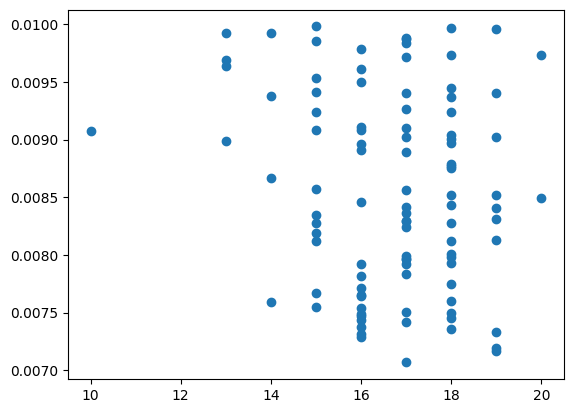

In [188]:
plt.scatter(ex_0["iters"], ex_0["solution_delta"])

In [189]:
dim_10_spectral_stats_agg = dim_10_spectral_stats.groupby("example_id").mean()

In [190]:
dim_10_spectral_stats_agg

,ev_ratio,solution_delta,iters
example_id,,,
0,66.719762,0.008553,16.68
1,400.612169,0.008574,16.17
2,104.195799,0.008136,13.95
3,76.152714,0.007088,9.52
4,512.360699,0.007386,10.56
...,...,...,...
95,131.589995,0.009263,31.22
96,125.663883,0.007448,9.09
97,261.880386,0.009630,48.69


In [191]:
np.corrcoef(dim_10_spectral_stats_agg["ev_ratio"], dim_10_spectral_stats_agg["iters"])

array([[1.        , 0.17860376],
       [0.17860376, 1.        ]])

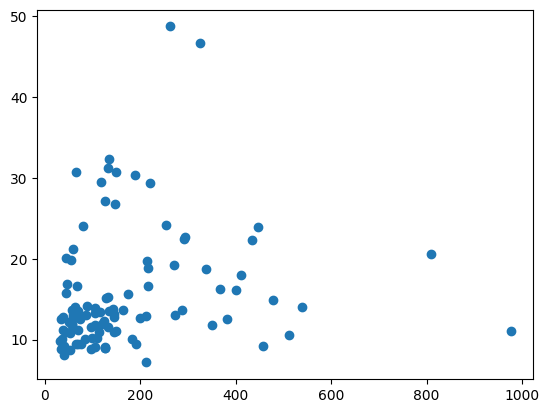

In [192]:
plt.scatter(dim_10_spectral_stats_agg["ev_ratio"], dim_10_spectral_stats_agg["iters"])

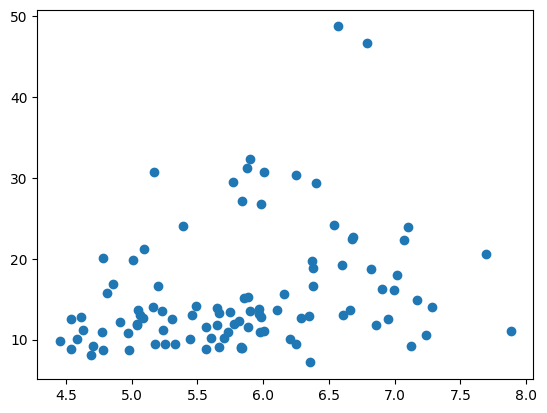

In [193]:
plt.scatter(np.log(dim_10_spectral_stats_agg["ev_ratio"])+1, dim_10_spectral_stats_agg["iters"])